In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm


def explorationAlgorithm(explorationAlgorithm, param, num_trials, noiseParams, **kwargs):
    cumulativeRewards = []
    for i in tqdm(range(num_trials)):
        # number of time steps
        t = 1000
        # number of arms, 10 in this instance
        k = 10
        # real reward distribution across K arms
        rewards = np.random.normal(1, 1, k)
        # counts for each arm
        n = np.zeros(k)
        # extract expected rewards by running specified exploration algorithm with the parameters above
        # param is the different, specific parameter for each exploration algorithm
        # this would be epsilon for epsilon greedy, initial values for optimistic intialization, c for UCB, and temperature for Boltmann
        currentRewards = explorationAlgorithm(
            param, t, k, rewards, n, noiseParams=noiseParams, **kwargs)
        cumulativeRewards.append(currentRewards)

    # TO DO: CALCULATE AVERAGE REWARDS ACROSS EACH ITERATION TO PRODUCE EXPECTED REWARDS
    expectedRewards = np.mean(cumulativeRewards, axis=0)
    assert len(expectedRewards) == t
    return expectedRewards


def init_qs(k, value=None) -> np.array:
    if value is None:
        qs = np.zeros(k)
    else:
        qs = np.ones(k) * value
    return qs


def argmax_tiebreak(arr: np.array) -> int:
    """arr: n x 1"""
    indices = np.argwhere(np.abs(arr - arr.max()) < 1e-9).flatten()
    if len(indices) == 0:
        return np.random.choice(arr.shape[0]) # randomly choose one
    return np.random.choice(indices)


def genObservedReward(arm, realRewards, noise_params=(0, 1)):
    noise = np.random.normal(noise_params[0], noise_params[1])
    return realRewards[arm] + noise


def plotExplorations(paramList, selectedAlgorithm, num_trials: int, paramLabelName="", num_steps=1000, noiseParams=(0, 1), **kwargs):
    # TO DO: for each parameter in the param list, plot the returns from the exploration Algorithm from each param on the same plot
    x = np.arange(1, 1001)
    # calculate your Ys (expected rewards) per each parameter value
    # plot all the Ys on the same plot
    # include correct labels on your plot!

    for param in paramList:
        expectedRewards = explorationAlgorithm(
            selectedAlgorithm, param=param, num_trials=num_trials, noiseParams=noiseParams, **kwargs)
        plt.plot(x, expectedRewards, label="=".join(
            [paramLabelName, str(param)]))
        plt.ylabel('Expected Rewards')
        plt.xlabel('Time steps')


## Epsilon

In [2]:
# EPSILON GREEDY TEMPLATE
def epsilonGreedy(epsilon, steps, k, realRewards, n, noiseParams):
    # TO DO: initialize structure to hold expected rewards per step
    expectedRewards = []
    # TO DO: initialize an initial q value for each arm
    qs = init_qs(k)
    # TO DO: implement the epsilon-greedy algorithm over all steps and return the expected rewards across all steps
    for step in range(steps):
        # TO DO: choose an arm based on epsilon greedy
        if random.random() < epsilon:
            arm = random.randint(0, k-1) # random lib: [a, b]
        else:
            arm = argmax_tiebreak(qs)

        observedReward = genObservedReward(arm, realRewards, noiseParams)
        n[arm] += 1
        qs[arm] = qs[arm] + (observedReward - qs[arm]) / n[arm]
        expectedRewards.append((1-epsilon) * np.max(qs) + np.sum(epsilon / k * qs))
    return expectedRewards


### Without noise

100%|██████████| 100/100 [00:01<00:00, 75.08it/s]


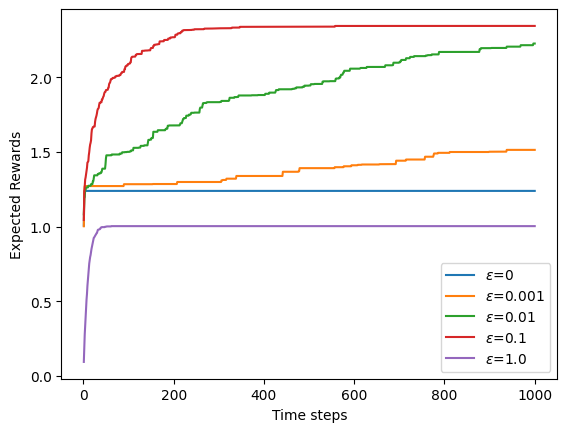

In [3]:
NUM_TRIALS = 100
allEps = [0, 0.001, 0.01, 0.1, 1.0]
# allEps = [0, 0.001]
plotExplorations(allEps, epsilonGreedy, 100,
                 paramLabelName=r"$\varepsilon$", num_steps=1000, noiseParams=(0, 0))
plt.legend()
plt.show()


### With noise from N(0, 1)

100%|██████████| 100/100 [00:01<00:00, 74.17it/s]


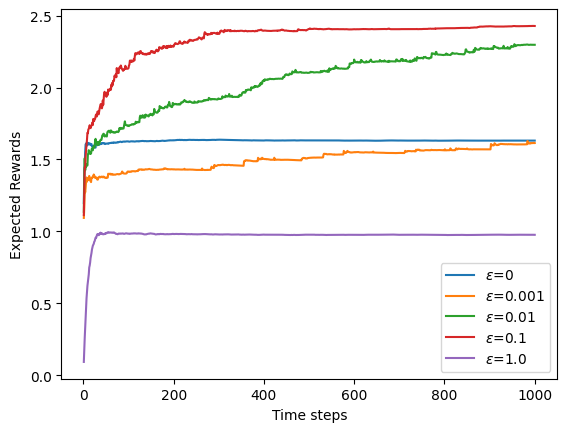

In [4]:
allEps = [0, 0.001, 0.01, 0.1, 1.0]
# allEps = [0, 0.001]
plotExplorations(allEps, epsilonGreedy, num_trials=100,
                 paramLabelName=r"$\varepsilon$", num_steps=1000, noiseParams=(0, 1))
plt.legend()
plt.show()


## Optimistic initialization

In [5]:
# OPTIMISTIC INTIALIZATION TEMPLATE
def optimisticInitialization(value, steps, k, realRewards, n, noiseParams):
    # TO DO: initialize structure to hold expected rewards per step
    expectedRewards = []
    # TO DO: initialize optimistic initial q values per arm specified by parameter
    qs = init_qs(k, value=value)
    # TO DO: implement the optimistic initializaiton algorithm over all steps and return the expected rewards across all steps
    for step in range(steps):
        # TO DO: choose an arm based on epsilon greedy
        arm = np.argmax(qs)
        observedReward = genObservedReward(arm, realRewards, noiseParams)
        expectedRewards.append(realRewards[arm])

        n[arm] += 1
        qs[arm] = qs[arm] + (observedReward - qs[arm]) / n[arm]

    return expectedRewards


### Without noises

100%|██████████| 100/100 [00:00<00:00, 258.48it/s]


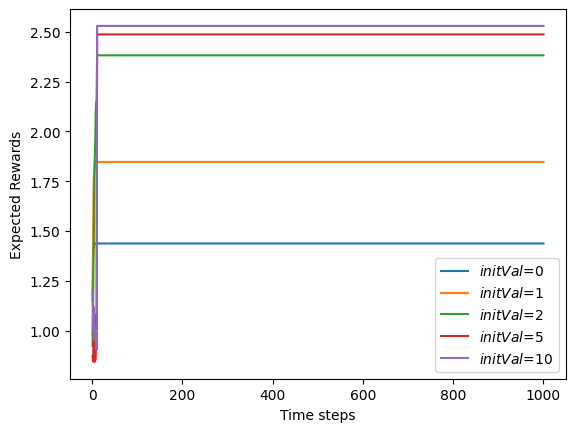

In [6]:
initValues = [0, 1, 2, 5, 10]
# allEps = [0, 0.001]
plotExplorations(initValues, optimisticInitialization, num_trials=100,
                 paramLabelName=r"$initVal$", num_steps=1000, noiseParams=(0, 0))
plt.legend()
plt.show()


### With noises sampled from N(0, 1)

100%|██████████| 100/100 [00:00<00:00, 261.58it/s]


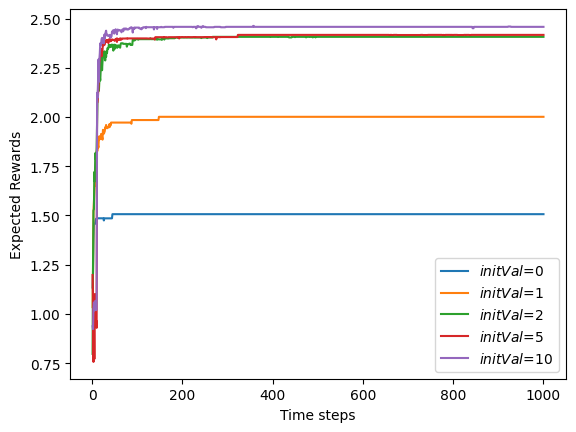

In [7]:
initValues = [0, 1, 2, 5, 10]
# allEps = [0, 0.001]
plotExplorations(initValues, optimisticInitialization, num_trials=100,
                 paramLabelName=r"$initVal$", num_steps=1000, noiseParams=(0, 1))
plt.legend()
plt.show()


## UCB

In [8]:

# UCB EXPLORATION TEMPLATE
def ucbExploration(c, steps, k, realRewards, n: np.array, noiseParams, pull_arm_once=True):
    # TO DO: initialize structure to hold expected rewards per step
    expectedRewards = []
    # TO DO: initialize q values per arm
    qs = init_qs(k)
    if pull_arm_once:
        for arm in range(k):
            qs[arm] = genObservedReward(arm, realRewards, noiseParams)
            n[arm] += 1
    # TO DO: implement the UCB exploration algorithm over all steps and return the expected rewards across all steps
    for step in range(0, steps):
        if not pull_arm_once:
            scores = qs + c * np.sqrt(np.log(step + 1) / (n + 1e-5)) # avoid divide by zero
        else:
            scores = qs + c * np.sqrt(np.log(step + 1) / n)

        # if step % 500 == 0:
        #     print("c: ", c, "step: ", step, "scores: ", scores)

        arm = argmax_tiebreak(scores)
        observedReward = genObservedReward(arm, realRewards, noiseParams)
        expectedRewards.append(realRewards[arm])

        n[arm] += 1
        qs[arm] = qs[arm] + (observedReward - qs[arm]) / n[arm]

    return expectedRewards


Check analytic reward solution with notebook example  

![Sutton&Barto text book result](sutton-barto-ucb-fig.png)


100%|██████████| 100/100 [00:03<00:00, 29.00it/s]


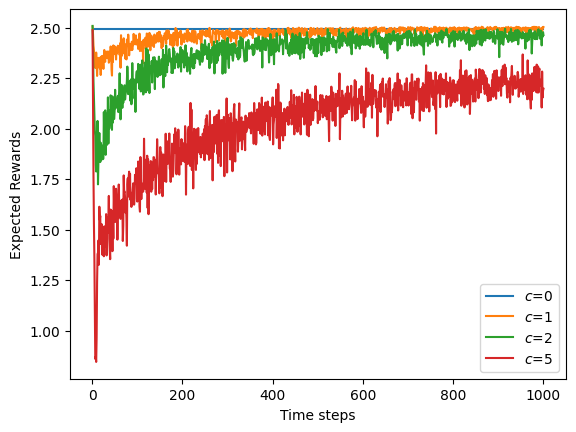

In [9]:
cs = [0, 1, 2, 5]
# cs = [2]
# allEps = [0, 0.001]
plotExplorations(cs, ucbExploration, num_trials=100,
                 paramLabelName=r"$c$", num_steps=1000, noiseParams=(0, 0))
plt.legend()
plt.show()


### noise from N(0, 1)

100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


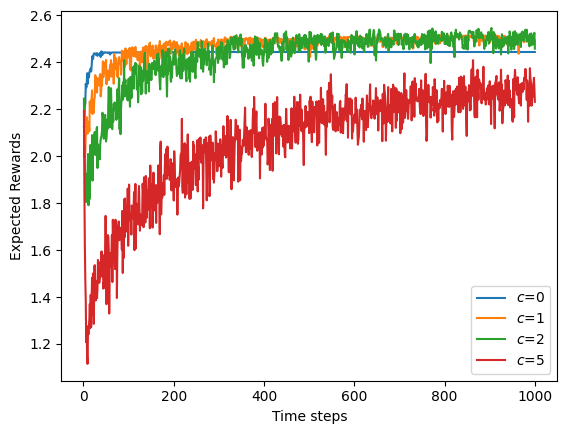

In [10]:
cs = [0, 1, 2, 5]
# allEps = [0, 0.001]
plotExplorations(cs, ucbExploration, num_trials=100,
                 paramLabelName=r"$c$", num_steps=1000, noiseParams=(0, 1))
plt.legend()
plt.show()


### Do NOT pull arm once for q initialization

100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


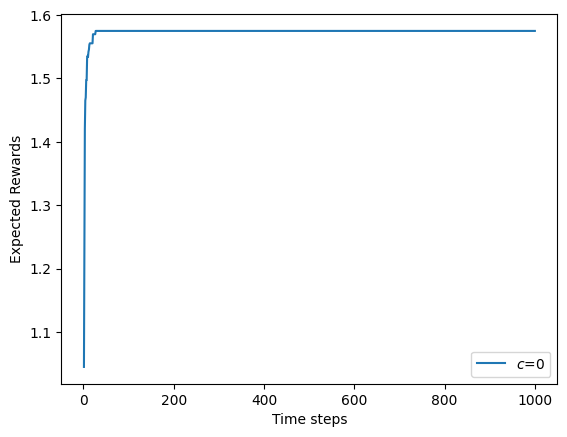

In [11]:
# cs = [0, 1, 2, 5]
cs = [0]
# allEps = [0, 0.001]
plotExplorations(cs, ucbExploration, num_trials=100,
                 paramLabelName=r"$c$", num_steps=1000, noiseParams=(0, 1), pull_arm_once=False)
plt.legend()
plt.show()


## Boltzman

In [12]:
# BOLTZMANN EXPLORATION TEMPLATE
def boltzmannE(temperature, steps, k, realRewards, n, noiseParams):
    expectedRewards = []
    qs = init_qs(k)

    for step in range(steps):
        # state copnfiguration for each state (arm)
        configs = np.exp(temperature * qs)
        config_probs = configs / (np.sum(configs))
        # arm = np.argmax(config_probs)
        arm = np.random.choice(k, p=config_probs)
        observedReward = genObservedReward(arm, realRewards, noiseParams)
        expectedRewards.append(np.sum(config_probs * realRewards))
        n[arm] += 1
        qs[arm] = qs[arm] + (observedReward - qs[arm]) / n[arm]

    return expectedRewards


### Fixed rewards without noises

100%|██████████| 100/100 [00:03<00:00, 28.75it/s]


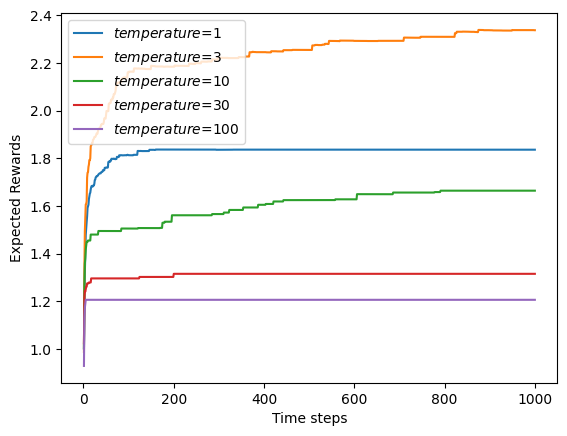

In [13]:
temperatures = [1, 3, 10, 30, 100]
# allEps = [0, 0.001]
plotExplorations(temperatures, boltzmannE, num_trials=100,
                 paramLabelName=r"$temperature$", num_steps=1000, noiseParams=(0, 0))
plt.legend()
plt.show()


### Withnoises from N(0, 1)

100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


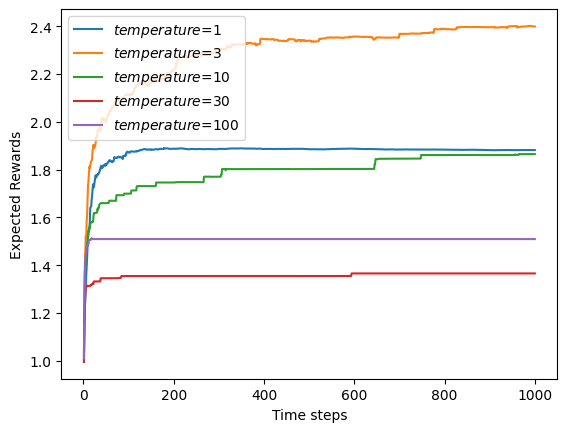

In [14]:
temperatures = [1, 3, 10, 30, 100]
# allEps = [0, 0.001]
plotExplorations(temperatures, boltzmannE, num_trials=100,
                 paramLabelName=r"$temperature$", num_steps=1000, noiseParams=(0, 1))
plt.legend()
plt.show()


## Q2.5 Compare the three exploration strategies by plotting the best-performing hyperparameter setting for each method. That is, create a single plot showing expected reward over 1000 time steps with three lines, corresponding to the best hyperparame- ters for ε-greedy, optimistic initialization, and UCB exploration.

In [15]:
# algorithms specific params
eps = 0.1
initVal = 5
ucb_c = 1
temperature = 3

# trials configs
noiseParams = (0, 1)
num_trials = 1000

epsExpectedRewards = explorationAlgorithm(
    epsilonGreedy, param=eps, num_trials=num_trials, noiseParams=noiseParams)

optimExpectedRewards = explorationAlgorithm(
    optimisticInitialization, param=initVal, num_trials=num_trials, noiseParams=noiseParams)

ucbExpectedRewards = explorationAlgorithm(
    ucbExploration, param=ucb_c, num_trials=num_trials, noiseParams=noiseParams)
boltzmannExpectedRewards = explorationAlgorithm(
    boltzmannE, param=temperature, num_trials=num_trials, noiseParams=noiseParams)


100%|██████████| 1000/1000 [00:35<00:00, 28.19it/s]


<AxesSubplot: >

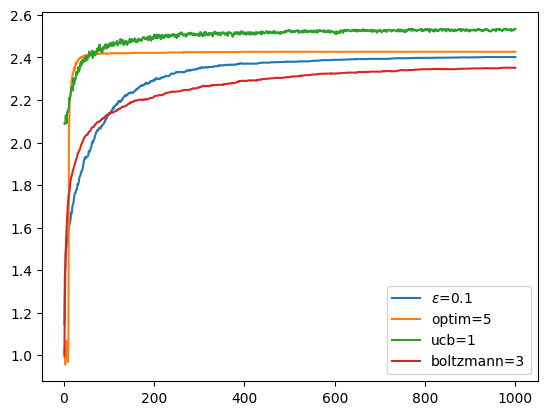

In [16]:
import seaborn as sns
xs = np.arange(1, 1000 + 1)
sns.lineplot(y=epsExpectedRewards, x=xs, label=r"$\varepsilon$=" + str(eps))
sns.lineplot(y=optimExpectedRewards, x=xs, label="optim=" + str(initVal))
sns.lineplot(y=ucbExpectedRewards, x=xs, label="ucb="+str(ucb_c))
sns.lineplot(y=boltzmannExpectedRewards, x=xs, label="boltzmann="+str(temperature))


## Q2.6  In 2-3 sentences, explain a setting where you might not want to use the best- performing exploration strategy you found above.